# **ЗАДАНИЕ 3** - РЕАЛИЗАЦИЯ АУГМЕНТАЦИЙ

## 1. Импорты

In [1]:
import random
import numpy as np
from PIL import Image
import torch

## 2. Базовый класс для всех трансформаций

In [2]:
class BaseTransform:
    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img: Image.Image) -> Image.Image:
        # вызывает трансформацию с вероятностью p
        if random.random() < self.p:
            return self.apply(img)
        else:
            return img

    def apply(self, img: Image.Image) -> Image.Image:
        raise NotImplementedError

## 3. RandomCrop

In [3]:
class RandomCrop(BaseTransform):
    def __init__(self, p: float = 0.5, crop_size=(50, 50)):
        super().__init__(p)
        self.crop_size = crop_size

    def apply(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        cw, ch = self.crop_size
        if cw > w or ch > h:
            return img  # если crop больше исходного, то возвращаем оригинал

        left = random.randint(0, w - cw)
        top = random.randint(0, h - ch)
        right = left + cw
        bottom = top + ch
        return img.crop((left, top, right, bottom))

## 4. RandomRotate

In [4]:
class RandomRotate(BaseTransform):
    def __init__(self, p: float = 0.5, max_angle: float = 30):
        super().__init__(p)
        self.max_angle = max_angle

    def apply(self, img: Image.Image) -> Image.Image:
        angle = random.uniform(-self.max_angle, self.max_angle)
        return img.rotate(angle)

## 5. RandomZoom

In [5]:
class RandomZoom(BaseTransform):
    def __init__(self, p: float = 0.5, zoom_range=(0.8, 1.2)):
        super().__init__(p)
        self.zoom_range = zoom_range

    def apply(self, img: Image.Image) -> Image.Image:
        zoom = random.uniform(*self.zoom_range)
        w, h = img.size
        new_w, new_h = int(w * zoom), int(h * zoom)
        img_zoomed = img.resize((new_w, new_h), Image.BICUBIC)

        # увеличили - обрезаем
        # уменьшили - добавляем поля
        if zoom > 1:
            left = (new_w - w) // 2
            top = (new_h - h) // 2
            img_zoomed = img_zoomed.crop((left, top, left + w, top + h))
        else:
            pad_w = (w - new_w) // 2
            pad_h = (h - new_h) // 2
            new_img = Image.new("RGB", (w, h))
            new_img.paste(img_zoomed, (pad_w, pad_h))
            img_zoomed = new_img

        return img_zoomed

## 6. ToTensor

In [6]:
class ToTensor:
    def __call__(self, img: Image.Image) -> torch.Tensor:
        arr = np.array(img, dtype=np.float32) / 255.0
        if arr.ndim == 2:
            arr = np.expand_dims(arr, axis=-1)
        # HWC -> CHW
        arr = np.transpose(arr, (2, 0, 1))
        return torch.tensor(arr, dtype=torch.float32)

## 7. Compose

In [7]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

## 8. Тесты

Тип результата: <class 'torch.Tensor'>
Форма тензора: torch.Size([3, 80, 80])
Диапазон значений: (0.0, 1.0)
Все тесты пройдены


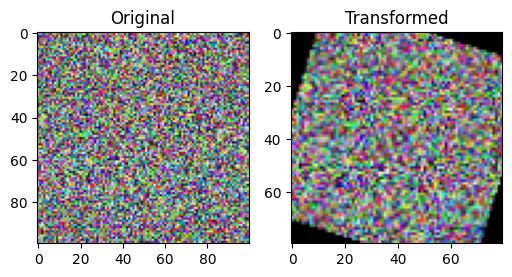

In [9]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)

    # тестовое изображение
    img = Image.fromarray(np.uint8(np.random.rand(100, 100, 3) * 255))

    transforms = Compose([
        RandomCrop(p=1.0, crop_size=(80, 80)),
        RandomRotate(p=1.0, max_angle=25),
        RandomZoom(p=1.0, zoom_range=(0.9, 1.1)),
        ToTensor()
    ])

    out = transforms(img)
    print("Тип результата:", type(out))
    print("Форма тензора:", out.shape)
    print("Диапазон значений:", (out.min().item(), out.max().item()))

    # граничные случаи
    no_aug = Compose([
        RandomCrop(p=0.0),
        RandomRotate(p=0.0),
        RandomZoom(p=0.0),
    ])

    same_img = no_aug(img)
    assert np.allclose(np.array(same_img), np.array(img)), "При p=0 изображение должно оставаться таким же"

    print("Все тесты пройдены")

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.title("Transformed")
    plt.imshow(out.permute(1,2,0).numpy())
    plt.show()